Каждый из нас писал в школе и университете изложения, сочинения, рефераты. А значит, в каждом из нас живет великий русский писатель.
В этой работе будем раскрывать свои таланты, находить себя в ряду таких гениев, как Пушкин, Гоголь, Грибоедов

В этой работе 
- скачаем корпус текстов 20-ми русских писателей. Каждый текст разобьем на обучающую и тестовую выборки.
- разработаем и обучим нейронную сеть определяющию авторство фрагментов текста (по тестовой выборке)
- скачаем СВОЕ сочинение (или чье-нибудь - есть в архиве). Сделаем из него проверочную выборку
- предложим нейронке предсказать автора сочинения (по проверочной выборке)
- объявим себя великим писателем, например, Гончаровым 

Ссылка на архив: https://storage.googleapis.com/datasets_ai/Data/writers25.zip

В работе рекомендуется пользоваться материалами из ноутбука практического занятия "Рекуррентные и одномерные сверточные нейронные сети". Допускается выбрать лучший вариант нейронки и адаптировать ее структуру, параметры обучения и формирования датасетов под свои *нужды*

In [69]:
import numpy as np  # Работа с массивами данных

import tensorflow as tf
# Функции-утилиты для работы с категориальными данными
from tensorflow.keras import utils
# Класс для конструирования последовательной модели нейронной сети
from tensorflow.keras.models import Sequential
# Основные слои
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, LSTM, MaxPooling1D
from tensorflow.keras.layers import Embedding, Flatten, Activation, Conv1D, GlobalMaxPooling1D, Bidirectional
# Токенизатор для преобразование текстов в последовательности
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import re     # Регулярные выражения
# Заполнение последовательностей до определенной длины
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # Матрица ошибок классификатора

import os    # Функции операционной системы
import zipfile
import time   # Работа со временем
import pickle # Запись в файлы и чтение из файлов структур данных Python
import codecs

import matplotlib.pyplot as plt # Отрисовка графиков
%matplotlib inline

In [ ]:
import gdown                                      

path = 'https://storage.googleapis.com/datasets_ai/Data/writers25.zip' 
gdown.download(path, quiet=False) 

Downloading...
From: https://storage.googleapis.com/datasets_ai/Data/writers25.zip
To: /content/writers25.zip
100%|██████████| 23.6M/23.6M [00:00<00:00, 117MB/s] 


'writers25.zip'

In [26]:
#extract the archive to local folder
!unzip -qo writers25.zip -d ./  

In [3]:
# split text on train and test dataset
def split_text(s):
  """ Partitions text into three parts
      in proportion 80%, 20%"""

  i1 = int(0.8*len(s))  # first part from 0 to i1

  # Use isalpha() to check when we are at a punctuation
  # i.e. . or ; or , or ? " or ' etc.
  # Find nearest alphanumeric boundary
  # backup as long as we are in an alphanumeric
  while s[i1].isalpha() and i1 > 0:
    i1 -= 1

  # Returns the three parts
  return s[:i1], s[i1:]

In [4]:
CLASS_LIST = []
text_train = []
text_test = []

for subdir, dirs, files in os.walk('./rec_1d/writters/'):
    for file in files:
        class_name = re.match('(.+)(?=(\.txt))', file)[0]
        #print(class_name)

        if class_name not in CLASS_LIST:
                print(f'Добавление класса "{class_name}"')
                CLASS_LIST.append(class_name)
                text_train.append('')
                text_test.append('')
        # Поиск индекса класса для добавления содержимого файла в \выборку
        cls = CLASS_LIST.index(class_name)

        with open(f'{subdir}/{file}', 'r', encoding = "windows-1251") as f:
            text = f.read()
        
        text_train[cls] += ' ' + split_text(text)[0].replace('\n', ' ')
        text_test[cls] += ' ' + split_text(text)[1].replace('\n', ' ')

Добавление класса "Лесков"
Добавление класса "Тургенев"
Добавление класса "Катаев"
Добавление класса "Васильев"
Добавление класса "Гоголь"
Добавление класса "Грибоедов"
Добавление класса "Беляев"
Добавление класса "Пастернак"
Добавление класса "Шолохов"
Добавление класса "Пушкин"
Добавление класса "Горький"
Добавление класса "Куприн"
Добавление класса "Носов"
Добавление класса "Булгаков"
Добавление класса "Каверин"
Добавление класса "Чехов"
Добавление класса "Толстой"
Добавление класса "Лермонтов"
Добавление класса "Достоевский"
Добавление класса "Гончаров"


In [5]:
CLASS_COUNT = len(CLASS_LIST)

In [6]:
print(f"{len(text_train)} texts' samples of {CLASS_COUNT} authors")
print(f"Class label's example: {CLASS_LIST[0]}")
print(f"  Text:{text_train[0][:200]}")

20 texts' samples of 20 authors
Class label's example: Лесков
  Text: РАЗБОЙНИК Ехали мы к Макарью на ярмарку*. Тарантас был огромный, тамбовский. Сидело нас пятеро: я, купец из Нижнего Ломова*, приказчик одного астраханского торгового дома, два молодца, состоящие при 


In [7]:
# data distribution
def data_summary(df, class_labels):
    for i, cls in enumerate(class_labels):
        print(f'Количество слов в классе {cls}:\
               {len([word for word in df[i].split()])}') 

data_summary(text_train, CLASS_LIST)

Количество слов в классе Лесков:               283077
Количество слов в классе Тургенев:               255117
Количество слов в классе Катаев:               313549
Количество слов в классе Васильев:               373447
Количество слов в классе Гоголь:               249105
Количество слов в классе Грибоедов:               123221
Количество слов в классе Беляев:               277294
Количество слов в классе Пастернак:               378043
Количество слов в классе Шолохов:               411991
Количество слов в классе Пушкин:               411685
Количество слов в классе Горький:               339676
Количество слов в классе Куприн:               288079
Количество слов в классе Носов:               308209
Количество слов в классе Булгаков:               246623
Количество слов в классе Каверин:               249739
Количество слов в классе Чехов:               853277
Количество слов в классе Толстой:               431004
Количество слов в классе Лермонтов:               253412
Количество 

In [8]:
# Задание параметров преобразования
VOCAB_SIZE = 20000                        # Объем словаря для токенизатора
WIN_SIZE   = 2000                         # Длина отрезка текста (окна) в словах
WIN_HOP    = 200                          # Шаг окна разбиения текста на векторы

In [9]:
# Токенизация и построение частотного словаря по обучающим текстам
# Используется встроенный в Keras токенизатор для разбиения текста и построения частотного словаря
tokenizer = Tokenizer(num_words=VOCAB_SIZE,
                      filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff',
                      lower=True,
                      split=' ',
                      oov_token='неизвестное_слово',
                      char_level=False)

# Использованы параметры:
# num_words   - объем словаря
# filters     - убираемые из текста ненужные символы
# lower       - приведение слов к нижнему регистру
# split       - разделитель слов
# char_level  - указание разделять по словам, а не по единичным символам
# oov_token   - токен для слов, которые не вошли в словарь

# Построение частотного словаря по обучающим текстам
tokenizer.fit_on_texts(text_train)

# Построение словаря в виде пар слово - индекс
items = list(tokenizer.word_index.items())

In [10]:
# Вывод нескольких наиболее часто встречающихся слов
print(items[:120])

# Размер словаря может быть больше, чем num_words, но при преобразовании в последовательности
# и векторы bag of words будут учтены только первые num_words слов
print("Размер словаря", len(items))

[('неизвестное_слово', 1), ('и', 2), ('в', 3), ('не', 4), ('на', 5), ('что', 6), ('с', 7), ('я', 8), ('он', 9), ('а', 10), ('как', 11), ('то', 12), ('его', 13), ('к', 14), ('но', 15), ('это', 16), ('по', 17), ('за', 18), ('у', 19), ('она', 20), ('все', 21), ('из', 22), ('так', 23), ('же', 24), ('от', 25), ('ты', 26), ('было', 27), ('вы', 28), ('да', 29), ('мне', 30), ('о', 31), ('меня', 32), ('ее', 33), ('бы', 34), ('только', 35), ('был', 36), ('ему', 37), ('еще', 38), ('когда', 39), ('вот', 40), ('сказал', 41), ('мы', 42), ('они', 43), ('ни', 44), ('до', 45), ('уже', 46), ('их', 47), ('нет', 48), ('ну', 49), ('для', 50), ('него', 51), ('или', 52), ('если', 53), ('ли', 54), ('теперь', 55), ('под', 56), ('быть', 57), ('вас', 58), ('себя', 59), ('где', 60), ('была', 61), ('очень', 62), ('во', 63), ('даже', 64), ('есть', 65), ('вам', 66), ('ничего', 67), ('со', 68), ('чем', 69), ('были', 70), ('может', 71), ('тут', 72), ('кто', 73), ('чтобы', 74), ('себе', 75), ('потом', 76), ('всё', 77),

In [11]:
# Преобразование входных текстов в последовательности индексов (для архитектур с embedding)
# Применено приведение к массиву объектов для дальнейшего разделения на выборки
seq_train = np.array(tokenizer.texts_to_sequences(text_train))
seq_test = np.array(tokenizer.texts_to_sequences(text_test))
# Вывод формы и примера данных
print(seq_train.shape) 
print(seq_train[0][:20])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until


(20,)
[4879, 2197, 42, 14, 1, 5, 19221, 8145, 36, 3013, 1, 11771, 87, 11772, 8, 2697, 22, 15730, 1, 4128]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  after removing the cwd from sys.path.


In [12]:
# Функция разбиения последовательности на отрезки скользящим окном
# На входе - последовательность индексов, размер окна, шаг окна
def split_sequence(sequence, win_size, hop):
    # Последовательность разбивается на части до последнего полного окна
    return [sequence[i:i + win_size] for i in range(0, len(sequence) - win_size + 1, hop)]


# Функция формирования выборок из последовательностей индексов
# формирует выборку отрезков и соответствующих им меток классов в виде one hot encoding
def vectorize_sequence(seq_list, win_size, hop):
    # В списке последовательности следуют в порядке их классов
    # Всего последовательностей в списке ровно столько, сколько классов
    class_count = len(seq_list)

    # Списки для исходных векторов и категориальных меток класса
    x, y = [], []

    # Для каждого класса:
    for cls in range(class_count):
        # Разбиение последовательности класса cls на отрезки
        vectors = split_sequence(seq_list[cls], win_size, hop)
        # Добавление отрезков в выборку
        x += vectors
        # Для всех отрезков класса cls добавление меток класса в виде OHE
        y += [utils.to_categorical(cls, class_count)] * len(vectors)

    # Возврат результатов как numpy-массивов
    return np.array(x), np.array(y)

In [13]:
    # Формирование обучающей выборки
    x_train, y_train = vectorize_sequence(seq_train, WIN_SIZE, WIN_HOP) 
    # Формирование тестовой выборки
    x_test, y_test = vectorize_sequence(seq_test, WIN_SIZE, WIN_HOP)

    # Проверка формы сформированных данных
    print(x_train.shape, y_train.shape)
    print(x_test.shape, y_test.shape)

(34447, 2000) (34447, 20)
(8517, 2000) (8517, 20)


In [14]:
# Формирование выборок текстов в виде разреженных матриц (bag of words)

# На входе .sequences_to_matrix() ожидает список, .tolist() выполняет преобразование типа
x_train_01 = tokenizer.sequences_to_matrix(x_train.tolist())
x_test_01 = tokenizer.sequences_to_matrix(x_test.tolist())

# Вывод формы обучающей выборки в виде разреженной матрицы Bag of Words
print(x_train_01.shape)       
# Вывод фрагмента отрезка обучающего текста в виде Bag of Words
print(x_train_01[0][0:100]) 

(34447, 20000)
[0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0.
 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.
 0. 1. 1. 1.]


In [15]:
# Функция компиляции и обучения модели нейронной сети
def compile_train_model(model, 
                        x_train,
                        y_train,
                        x_val,
                        y_val,
                        optimizer='adam',
                        epochs=50,
                        batch_size=128,
                        figsize=(20, 5)):

    # Компиляция модели
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

    # Вывод сводки
    model.summary()

    # Обучение модели с заданными параметрами
    history = model.fit(x_train,
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(x_val, y_val))

    # Вывод графиков точности и ошибки
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle('График процесса обучения модели')
    ax1.plot(history.history['accuracy'], 
               label='Доля верных ответов на обучающем наборе')
    ax1.plot(history.history['val_accuracy'], 
               label='Доля верных ответов на проверочном наборе')
    ax1.xaxis.get_major_locator().set_params(integer=True)
    ax1.set_xlabel('Эпоха обучения')
    ax1.set_ylabel('Доля верных ответов')
    ax1.legend()

    ax2.plot(history.history['loss'], 
               label='Ошибка на обучающем наборе')
    ax2.plot(history.history['val_loss'], 
               label='Ошибка на проверочном наборе')
    ax2.xaxis.get_major_locator().set_params(integer=True)
    ax2.set_xlabel('Эпоха обучения')
    ax2.set_ylabel('Ошибка')
    ax2.legend()
    plt.show()


# Функция вывода результатов оценки модели на заданных данных
def eval_model(model, x, y_true,
               class_labels=[],
               cm_round=3,
               title='',
               figsize=(10, 10)):
    # Вычисление предсказания сети
    y_pred = model.predict(x)
    # Построение матрицы ошибок
    cm = confusion_matrix(np.argmax(y_true, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')
    # Округление значений матрицы ошибок
    cm = np.around(cm, cm_round)

    # Отрисовка матрицы ошибок
    # fig, ax = plt.subplots(figsize=figsize)
    # ax.set_title(f'Нейросеть {title}: матрица ошибок нормализованная', fontsize=18)
    # disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    # disp.plot(ax=ax)
    # plt.gca().images[-1].colorbar.remove()  # Стирание ненужной цветовой шкалы
    # plt.xlabel('Предсказанные классы', fontsize=16)
    # plt.ylabel('Верные классы', fontsize=16)
    # fig.autofmt_xdate(rotation=45)          # Наклон меток горизонтальной оси при необходимости
    # plt.show()    

    print('-'*100)
    print(f'Нейросеть: {title}')

    # Для каждого класса:
    for cls in range(len(class_labels)):
        # Определяется индекс класса с максимальным значением предсказания (уверенности)
        cls_pred = np.argmax(cm[cls])
        # Формируется сообщение о верности или неверности предсказания
        msg = 'ВЕРНО :-)' if cls_pred == cls else 'НЕВЕРНО :-('
        # Выводится текстовая информация о предсказанном классе и значении уверенности
        print('Класс: {:<20} {:3.0f}% сеть отнесла к классу {:<20} - {}'.format(class_labels[cls],
                                                                               100. * cm[cls, cls_pred],
                                                                               class_labels[cls_pred],
                                                                               msg))

    # Средняя точность распознавания определяется как среднее диагональных элементов матрицы ошибок
    print('\nСредняя точность распознавания: {:3.0f}%'.format(100. * cm.diagonal().mean()))


# Совместная функция обучения и оценки модели нейронной сети
def compile_train_eval_model(model, 
                             x_train,
                             y_train,
                             x_test,
                             y_test,
                             class_labels=CLASS_LIST,
                             title='',
                             optimizer='adam',
                             epochs=50,
                             batch_size=128,
                             graph_size=(20, 5),
                             cm_size=(10, 10)):

    # Компиляция и обучение модели на заданных параметрах
    # В качестве проверочных используются тестовые данные
    compile_train_model(model, 
                        x_train, y_train,
                        x_test, y_test,
                        optimizer=optimizer,
                        epochs=epochs,
                        batch_size=batch_size,
                        figsize=graph_size)

    # Вывод результатов оценки работы модели на тестовых данных
    eval_model(model, x_test, y_test, 
               class_labels=class_labels, 
               title=title,
               figsize=cm_size)

In [16]:
# Снижение размерности входных данных:
# ограничение длины последовательностей до разумного предела
seq_max_len = 1000
x_train_clip = pad_sequences(x_train, maxlen=seq_max_len)
x_test_clip = pad_sequences(x_test, maxlen=seq_max_len)

# Проверка формы результата
print(x_train_clip.shape, x_test_clip.shape)

(34447, 1000) (8517, 1000)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 200)         4000000   
                                                                 
 conv1d (Conv1D)             (None, 331, 128)          256128    
                                                                 
 conv1d_1 (Conv1D)           (None, 108, 256)          327936    
                                                                 
 global_max_pooling1d (Globa  (None, 256)              0         
 lMaxPooling1D)                                                  
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                          

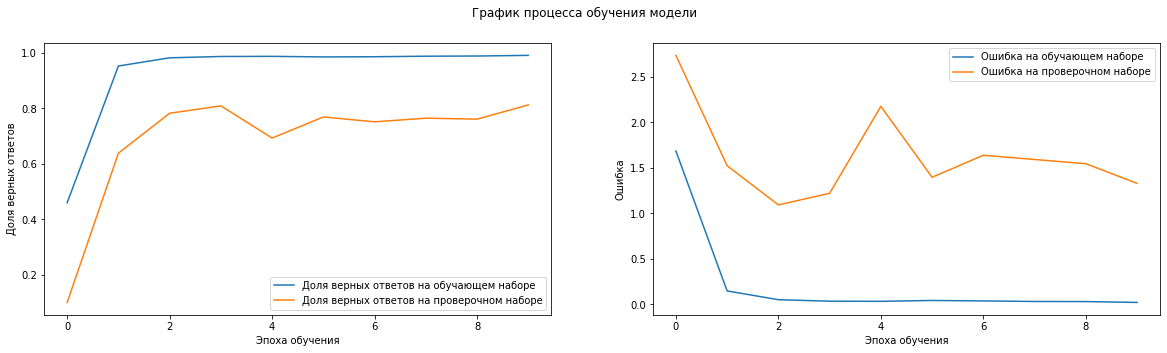

----------------------------------------------------------------------------------------------------
Нейросеть: Embedding/20
Класс: Лесков                74% сеть отнесла к классу Лесков               - ВЕРНО :-)
Класс: Тургенев              45% сеть отнесла к классу Тургенев             - ВЕРНО :-)
Класс: Катаев                67% сеть отнесла к классу Катаев               - ВЕРНО :-)
Класс: Васильев             100% сеть отнесла к классу Васильев             - ВЕРНО :-)
Класс: Гоголь                68% сеть отнесла к классу Гоголь               - ВЕРНО :-)
Класс: Грибоедов             94% сеть отнесла к классу Грибоедов            - ВЕРНО :-)
Класс: Беляев                56% сеть отнесла к классу Беляев               - ВЕРНО :-)
Класс: Пастернак             94% сеть отнесла к классу Пастернак            - ВЕРНО :-)
Класс: Шолохов               86% сеть отнесла к классу Шолохов              - ВЕРНО :-)
Класс: Пушкин                76% сеть отнесла к классу Пушкин               - ВЕРНО

In [18]:
#Создаём сеть с Embedding слоем
model_text_emb_200 = Sequential()
model_text_emb_200.add(Embedding(VOCAB_SIZE, 200, input_length=seq_max_len))

model_text_emb_200.add(Conv1D(128, 10, padding="valid", activation="relu", strides=3))
model_text_emb_200.add(Conv1D(256, 10, padding="valid", activation="relu", strides=3))
model_text_emb_200.add(GlobalMaxPooling1D())

#model_text_emb_200.add(SpatialDropout1D(0.2))
model_text_emb_200.add(Flatten())
model_text_emb_200.add(BatchNormalization())
model_text_emb_200.add(Dense(200, activation="relu"))
model_text_emb_200.add(Dropout(0.3))
model_text_emb_200.add(Dense(200, activation="relu"))
model_text_emb_200.add(Dropout(0.3))
#model_text_emb_200.add(BatchNormalization())
model_text_emb_200.add(Dense(CLASS_COUNT, activation='softmax'))

compile_train_eval_model(model_text_emb_200,
                         x_train_clip, y_train,
                         x_test_clip, y_test,
                         epochs=10,
                         class_labels=CLASS_LIST,
                         title='Embedding/20')

In [20]:
#save model
model_text_emb_200.save('writters_model.h5')

# authorize to google disk's account
from google.colab import drive
drive.mount('/content/drive')

#save model to google disk
!cp writters_model.h5 /content/drive/MyDrive/Colab_support/

Mounted at /content/drive


In [ ]:
# load presaved model
from google.colab import drive
from tensorflow.keras.models import load_model

drive.mount('/content/drive')

!cp /content/drive/MyDrive/Colab_support/writters_model.h5 /content/

model_text_emb_200 = load_model('writters_model.h5') 

## Make prediction on our example

In [22]:
subdir = ''
with open(f'./rec_1d/refer/островский.txt', 'r', encoding = "windows-1251") as f:
            text = f.read()

sample2predict = text

In [30]:
sample2predict[:200]

'ВВЕДЕНИЕ\n«Гроза» – одна из самых ярких, необычных и острых по проблематике  пьес русского репертуара. На  протяжении почти полутора столетий отношение к драме не устоялось, каждая новая театральная по'

### Preproccess the example to the appropriate form

In [49]:
# Построение частотного словаря по тестовому тексту
tokenizer.fit_on_texts([sample2predict])

# Преобразование входных текстов в последовательности индексов (для архитектур с embedding)
# Применено приведение к массиву объектов для дальнейшего разделения на выборки
seq_predict = np.array(tokenizer.texts_to_sequences([sample2predict]))

# Снижение размерности входных данных:
# ограничение длины последовательностей до разумного предела
seq_max_len = 1000
x_predict_clip = pad_sequences(seq_predict, maxlen=seq_max_len)

In [66]:
# make prediction
y_pred = model_text_emb_200.predict(x_predict_clip)

pred = np.argmax(y_pred)
CLASS_LIST[pred]

'Каверин'

In [63]:
#show all predictions in the ascending order
zipped_lists = zip(y_pred.tolist()[0], CLASS_LIST)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
list1, list2 = [list(tuple) for tuple in tuples]

In [64]:
list1

[2.1181516984825066e-08,
 1.1284287211310584e-06,
 1.4828784742348944e-06,
 3.4765873806463787e-06,
 4.7031630856508855e-06,
 5.129319106345065e-06,
 5.291338766255649e-06,
 2.3005559341982007e-05,
 3.807029133895412e-05,
 0.00016007537487894297,
 0.0002951135393232107,
 0.0004957360215485096,
 0.0010012075072154403,
 0.0012723950203508139,
 0.002197669353336096,
 0.004662806633859873,
 0.019661732017993927,
 0.030154893174767494,
 0.04222505912184715,
 0.8977909088134766]

In [65]:
list2

['Тургенев',
 'Горький',
 'Чехов',
 'Гончаров',
 'Гоголь',
 'Лермонтов',
 'Толстой',
 'Куприн',
 'Лесков',
 'Достоевский',
 'Пушкин',
 'Беляев',
 'Пастернак',
 'Катаев',
 'Васильев',
 'Носов',
 'Шолохов',
 'Грибоедов',
 'Булгаков',
 'Каверин']

## Alternative model

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 1000, 200)         4000000   
                                                                 
 bidirectional_2 (Bidirectio  (None, 1000, 8)          6560      
 nal)                                                            
                                                                 
 max_pooling1d (MaxPooling1D  (None, 500, 8)           0         
 )                                                               
                                                                 
 dropout_3 (Dropout)         (None, 500, 8)            0         
                                                                 
 conv1d_5 (Conv1D)           (None, 164, 128)          10368     
                                                                 
 dropout_4 (Dropout)         (None, 164, 128)         

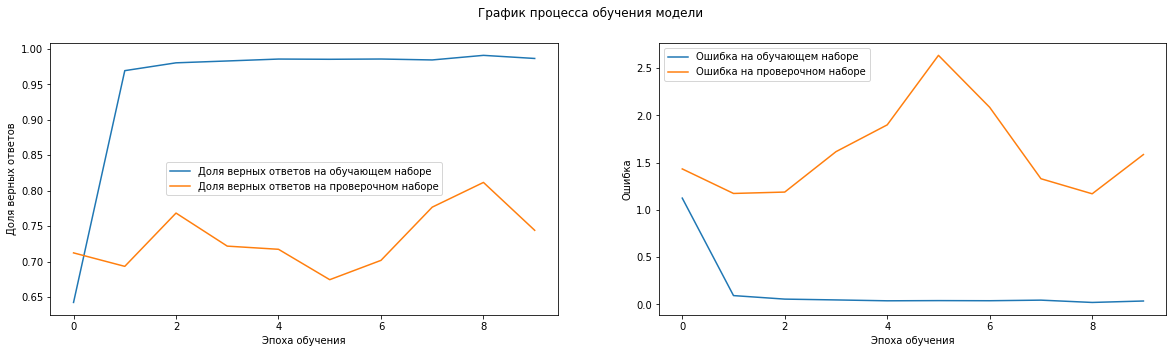

----------------------------------------------------------------------------------------------------
Нейросеть: Embedding/20
Класс: Лесков                69% сеть отнесла к классу Лесков               - ВЕРНО :-)
Класс: Тургенев              43% сеть отнесла к классу Куприн               - НЕВЕРНО :-(
Класс: Катаев                89% сеть отнесла к классу Катаев               - ВЕРНО :-)
Класс: Васильев             100% сеть отнесла к классу Васильев             - ВЕРНО :-)
Класс: Гоголь                61% сеть отнесла к классу Гоголь               - ВЕРНО :-)
Класс: Грибоедов             55% сеть отнесла к классу Грибоедов            - ВЕРНО :-)
Класс: Беляев                31% сеть отнесла к классу Беляев               - ВЕРНО :-)
Класс: Пастернак             81% сеть отнесла к классу Пастернак            - ВЕРНО :-)
Класс: Шолохов               93% сеть отнесла к классу Шолохов              - ВЕРНО :-)
Класс: Пушкин                63% сеть отнесла к классу Пушкин               - ВЕР

In [71]:
#Создаём сеть с Embedding слоем
model_text_emb_lstm = Sequential()
model_text_emb_lstm.add(Embedding(VOCAB_SIZE, 200, input_length=seq_max_len))

model_text_emb_lstm.add(Bidirectional(LSTM(4, return_sequences=1)))
# Слой подвыборки/пулинга с функцией максимума
model_text_emb_lstm.add(MaxPooling1D(2))
model_text_emb_lstm.add(Dropout(0.2))

model_text_emb_lstm.add(Conv1D(128, 10, padding="valid", activation="relu", strides=3))
model_text_emb_lstm.add(Dropout(0.3))
model_text_emb_lstm.add(Conv1D(256, 10, padding="same", activation="relu", strides=3))
model_text_emb_lstm.add(GlobalMaxPooling1D())

#model_text_emb_lstm.add(SpatialDropout1D(0.2))
model_text_emb_lstm.add(Flatten())
model_text_emb_lstm.add(BatchNormalization())
model_text_emb_lstm.add(Dense(200, activation="relu"))
model_text_emb_lstm.add(Dropout(0.3))
model_text_emb_lstm.add(Dense(200, activation="relu"))
model_text_emb_lstm.add(Dropout(0.3))
#model_text_emb_lstm.add(BatchNormalization())
model_text_emb_lstm.add(Dense(CLASS_COUNT, activation='softmax'))

compile_train_eval_model(model_text_emb_lstm,
                         x_train_clip, y_train,
                         x_test_clip, y_test,
                         epochs=10,
                         class_labels=CLASS_LIST,
                         title='Embedding/20')